In [ ]:
import xarray as xr
import numpy  as np
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import copy

# 计算频率图

2022.02.16

绘制平均态的bar图，相比下面精细bins的频率图更笼统；运行type1

2022.02.17 type2

在此前PDF分布的绘制上的改进；将3D的所有子区域的格点的值考虑进了PDF的统计结果中；

降水需要针对湿日进行PDF的绘制，统计大于0.1mm/d以上的格点；在湿日中的占比

绘制上，降水采用了对数坐标；使用小图绘制了极端状况（50-100mm/d）NWC在小图部分采用了常见的linear坐标

## 数据读取

### 日降水

In [ ]:
# 提取AM & JJA的降水的时间序列
# get partial mask_res collect into a dict
partial_list = ["NE", "NC","NWC", "YZ", "SC","SW"]
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre"
file_ref= "obsmerge_pre_98-17.nc"
file_vr = "vr_pre_98-17.nc"
file_rcm = "rcm_pre_98-17.nc"

partial_mean = {} # partial mask_res
partial_mean['precip'] = {}

for iregion in partial_list:
    partial_mean['precip'][iregion] = {}
    path_in_partial = path_in + "/" + iregion + "/ordata" # refine path
    print(path_in_partial)

    # obs
    xr_obs = xr.open_dataset(path_in_partial + "/" + file_ref)['premerge']
    xr_obs = xr_obs.reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords
    partial_mean['precip'][iregion]['obs'] = xr_obs.sel(time = xr_obs.time.dt.month.isin([5,6,7,8]))

    # vr
    xr_vr = xr.open_dataset(path_in_partial + "/" + file_vr)['precip_MPAS']
    partial_mean['precip'][iregion]['vr'] = xr_vr.sel(Time = xr_vr.Time.dt.month.isin([5,6,7,8]))

    # rcm
    xr_rcm = xr.open_dataset(path_in_partial + "/" + file_rcm)['precip_MPAS']
    partial_mean['precip'][iregion]['rcm'] = xr_rcm.sel(Time = xr_rcm.Time.dt.month.isin([5,6,7,8]))

### 日平均气温

In [ ]:
# 提取AM & JJA的降水的时间序列
# get partial mask_res collect into a dict
partial_list = ["NE", "NC", "YZ", "SC",'SW','NWC']
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m"
file_ref= "mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
file_vr = "mask_mean_t2m_98-17_VR.nc"
file_rcm = "mask_mean_t2m_98-17_RCM.nc"

partial_mean['t2m'] = {}

for iregion in partial_list:
    partial_mean['t2m'][iregion] = {}
    path_in_partial = path_in + "/" + iregion + "/ordata" # refine path
    print(path_in_partial)

    # obs
    xr_obs = xr.open_dataset(path_in_partial + "/" + file_ref)['tm']
    partial_mean['t2m'][iregion]['obs'] = xr_obs.sel(time = xr_obs.time.dt.month.isin([5,6,7,8]))

    # vr
    xr_vr = xr.open_dataset(path_in_partial + "/" + file_vr)['t2m']
    partial_mean['t2m'][iregion]['vr'] = xr_vr.sel(Time = xr_vr.Time.dt.month.isin([5,6,7,8])) - 273.15

    # rcm
    xr_rcm = xr.open_dataset(path_in_partial + "/" + file_rcm)['t2m']
    partial_mean['t2m'][iregion]['rcm'] = xr_rcm.sel(Time = xr_rcm.Time.dt.month.isin([5,6,7,8])) - 273.15

## 计算部分

### bins使用的直方图方法，进行向量化

In [88]:
def get_bins_interval(bins):
    """
    用于生成左闭右开的区间字符串
    """
    freq_bins_left = bins[0:-1] # 左区间
    freq_bins_right = bins[1:] # 右区间
    freq_bins_str = []
    for interval_ind in range(0,len(freq_bins_left)):
        if (interval_ind == len(freq_bins_left) - 1 ):
            str_temp = '[' + str(freq_bins_left[interval_ind]) + "," + str(freq_bins_right[interval_ind]) + "]"
        else:
            str_temp = '[' + str(freq_bins_left[interval_ind]) + "," + str(freq_bins_right[interval_ind]) + ")"
        freq_bins_str.append(str_temp)
    return freq_bins_str

def count_freq_every_gird(arr,bins_1d):
    """
    用于计算3D的序列上，在每个格点上的freq的状况
    """ 
    # ntimes = arr.shape[0]
    res_3d,bins_3d = np.apply_along_axis(func1d = np.histogram,axis = 0, arr = arr, bins = bins_1d) # 时间维的每个格点上计算 freq
    freq_sum = np.sum(res_3d[:,:]) # 获取区域全部频率sum结果

    freq_sum_normal = freq_sum / freq_sum.sum() # 在降水日中进行归一化

    # grid_points = 1
    # for i in arr.shape[:]:
        # grid_points = grid_points * i
    # freq_sum_normal = freq_sum / grid_points # 在全部日期中进行归一化

    return freq_sum_normal

### 计算 type1 准备bins + 条形图

In [100]:
# 进行频率估计的数据准备
var_hist   = copy.deepcopy(partial_mean) # 存放直方图
var_kernel = copy.deepcopy(partial_mean) # 存放核密度估计结果
var_bins   = copy.deepcopy(partial_mean) # 存放x轴 bins

# 制作bins区间、区间标签
freq_bins = {}
# freq_bins['precip'] = np.arange(0,53,5)
freq_bins['precip'] = np.array([0,5,10,25,50,75,100,200])
freq_bins['t2m']    = np.arange(-15,45,5)
str_bins  = {}
str_bins['precip']  = get_bins_interval(freq_bins['precip'])
str_bins['t2m']  = get_bins_interval(freq_bins['t2m'])

# 创建每个区域的df
df_plot = {}
for vartype in partial_mean.keys():
    df_plot[vartype] = {}
    for iregion in partial_mean[vartype].keys():
        df_plot[vartype][iregion] = pd.DataFrame(
            columns=pd.Index(["obs", "vr","rcm"], name='freq bins'),
            index=str_bins[vartype])

for vartype in partial_mean.keys():
    for iregion in partial_mean[vartype].keys():
        for imod in partial_mean[vartype][iregion].keys():
                var_np = partial_mean[vartype][iregion][imod].values
                # 对于降水，去除掉日降水小于1的部分
                if (vartype == 'precip'):
                    var_np = np.where(var_np<=0.1, np.nan, var_np)
                histogram = count_freq_every_gird(arr = var_np, bins_1d = freq_bins[vartype])
                # add to df
                df_plot[vartype][iregion][imod] = histogram

<ipython-input-100-7bbda7bec070>:30: RuntimeWarning: invalid value encountered in less_equal
  var_np = np.where(var_np<=0.1, np.nan, var_np)


### 计算 type2 准备 bins密集的曲线图

In [89]:
# 进行频率估计的数据准备
var_hist   = copy.deepcopy(partial_mean) # 存放直方图
var_kernel = copy.deepcopy(partial_mean) # 存放核密度估计结果
var_bins   = copy.deepcopy(partial_mean) # 存放x轴 bins

# 制作bins区间、区间标签
freq_bins = {}
# freq_bins['precip'] = np.arange(0,53,5)
freq_bins['precip'] = np.arange(0,205,1)
freq_bins['t2m']    = np.arange(-15,45,1)
str_bins  = {}
str_bins['precip']  = get_bins_interval(freq_bins['precip'])
str_bins['t2m']  = get_bins_interval(freq_bins['t2m'])

# 创建每个区域的df
df_plot = {}
for vartype in partial_mean.keys():
    df_plot[vartype] = {}
    for iregion in partial_mean[vartype].keys():
        df_plot[vartype][iregion] = pd.DataFrame(
            columns=pd.Index(["obs", "vr","rcm"], name='freq bins'),
            index=freq_bins[vartype][0:-1])

# for vartype in ['precip','t2m']:
for vartype in partial_mean.keys():
    for iregion in partial_mean[vartype].keys():
        for imod in partial_mean[vartype][iregion].keys():
                var_np = partial_mean[vartype][iregion][imod].values
                # 对于降水，去除掉日降水小于1的部分
                if (vartype == 'precip'):
                    var_np = np.where(var_np<0.1, np.nan, var_np)
                histogram = count_freq_every_gird(arr = var_np, bins_1d = freq_bins[vartype])
                # add to df
                df_plot[vartype][iregion][imod] = histogram
        # break

<ipython-input-89-7a2ba72f3563>:31: RuntimeWarning: invalid value encountered in less
  var_np = np.where(var_np<0.1, np.nan, var_np)


## 绘图部分

### type1 绘制频率bar图

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:85: FutureWarning: Conversion of the second argument of issubdtype from `object` to `np.generic` is deprecated. In future, it will be treated as `np.object_ == np.dtype(object).type`.
  or np.issubdtype(array.dtype, np.object)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/si

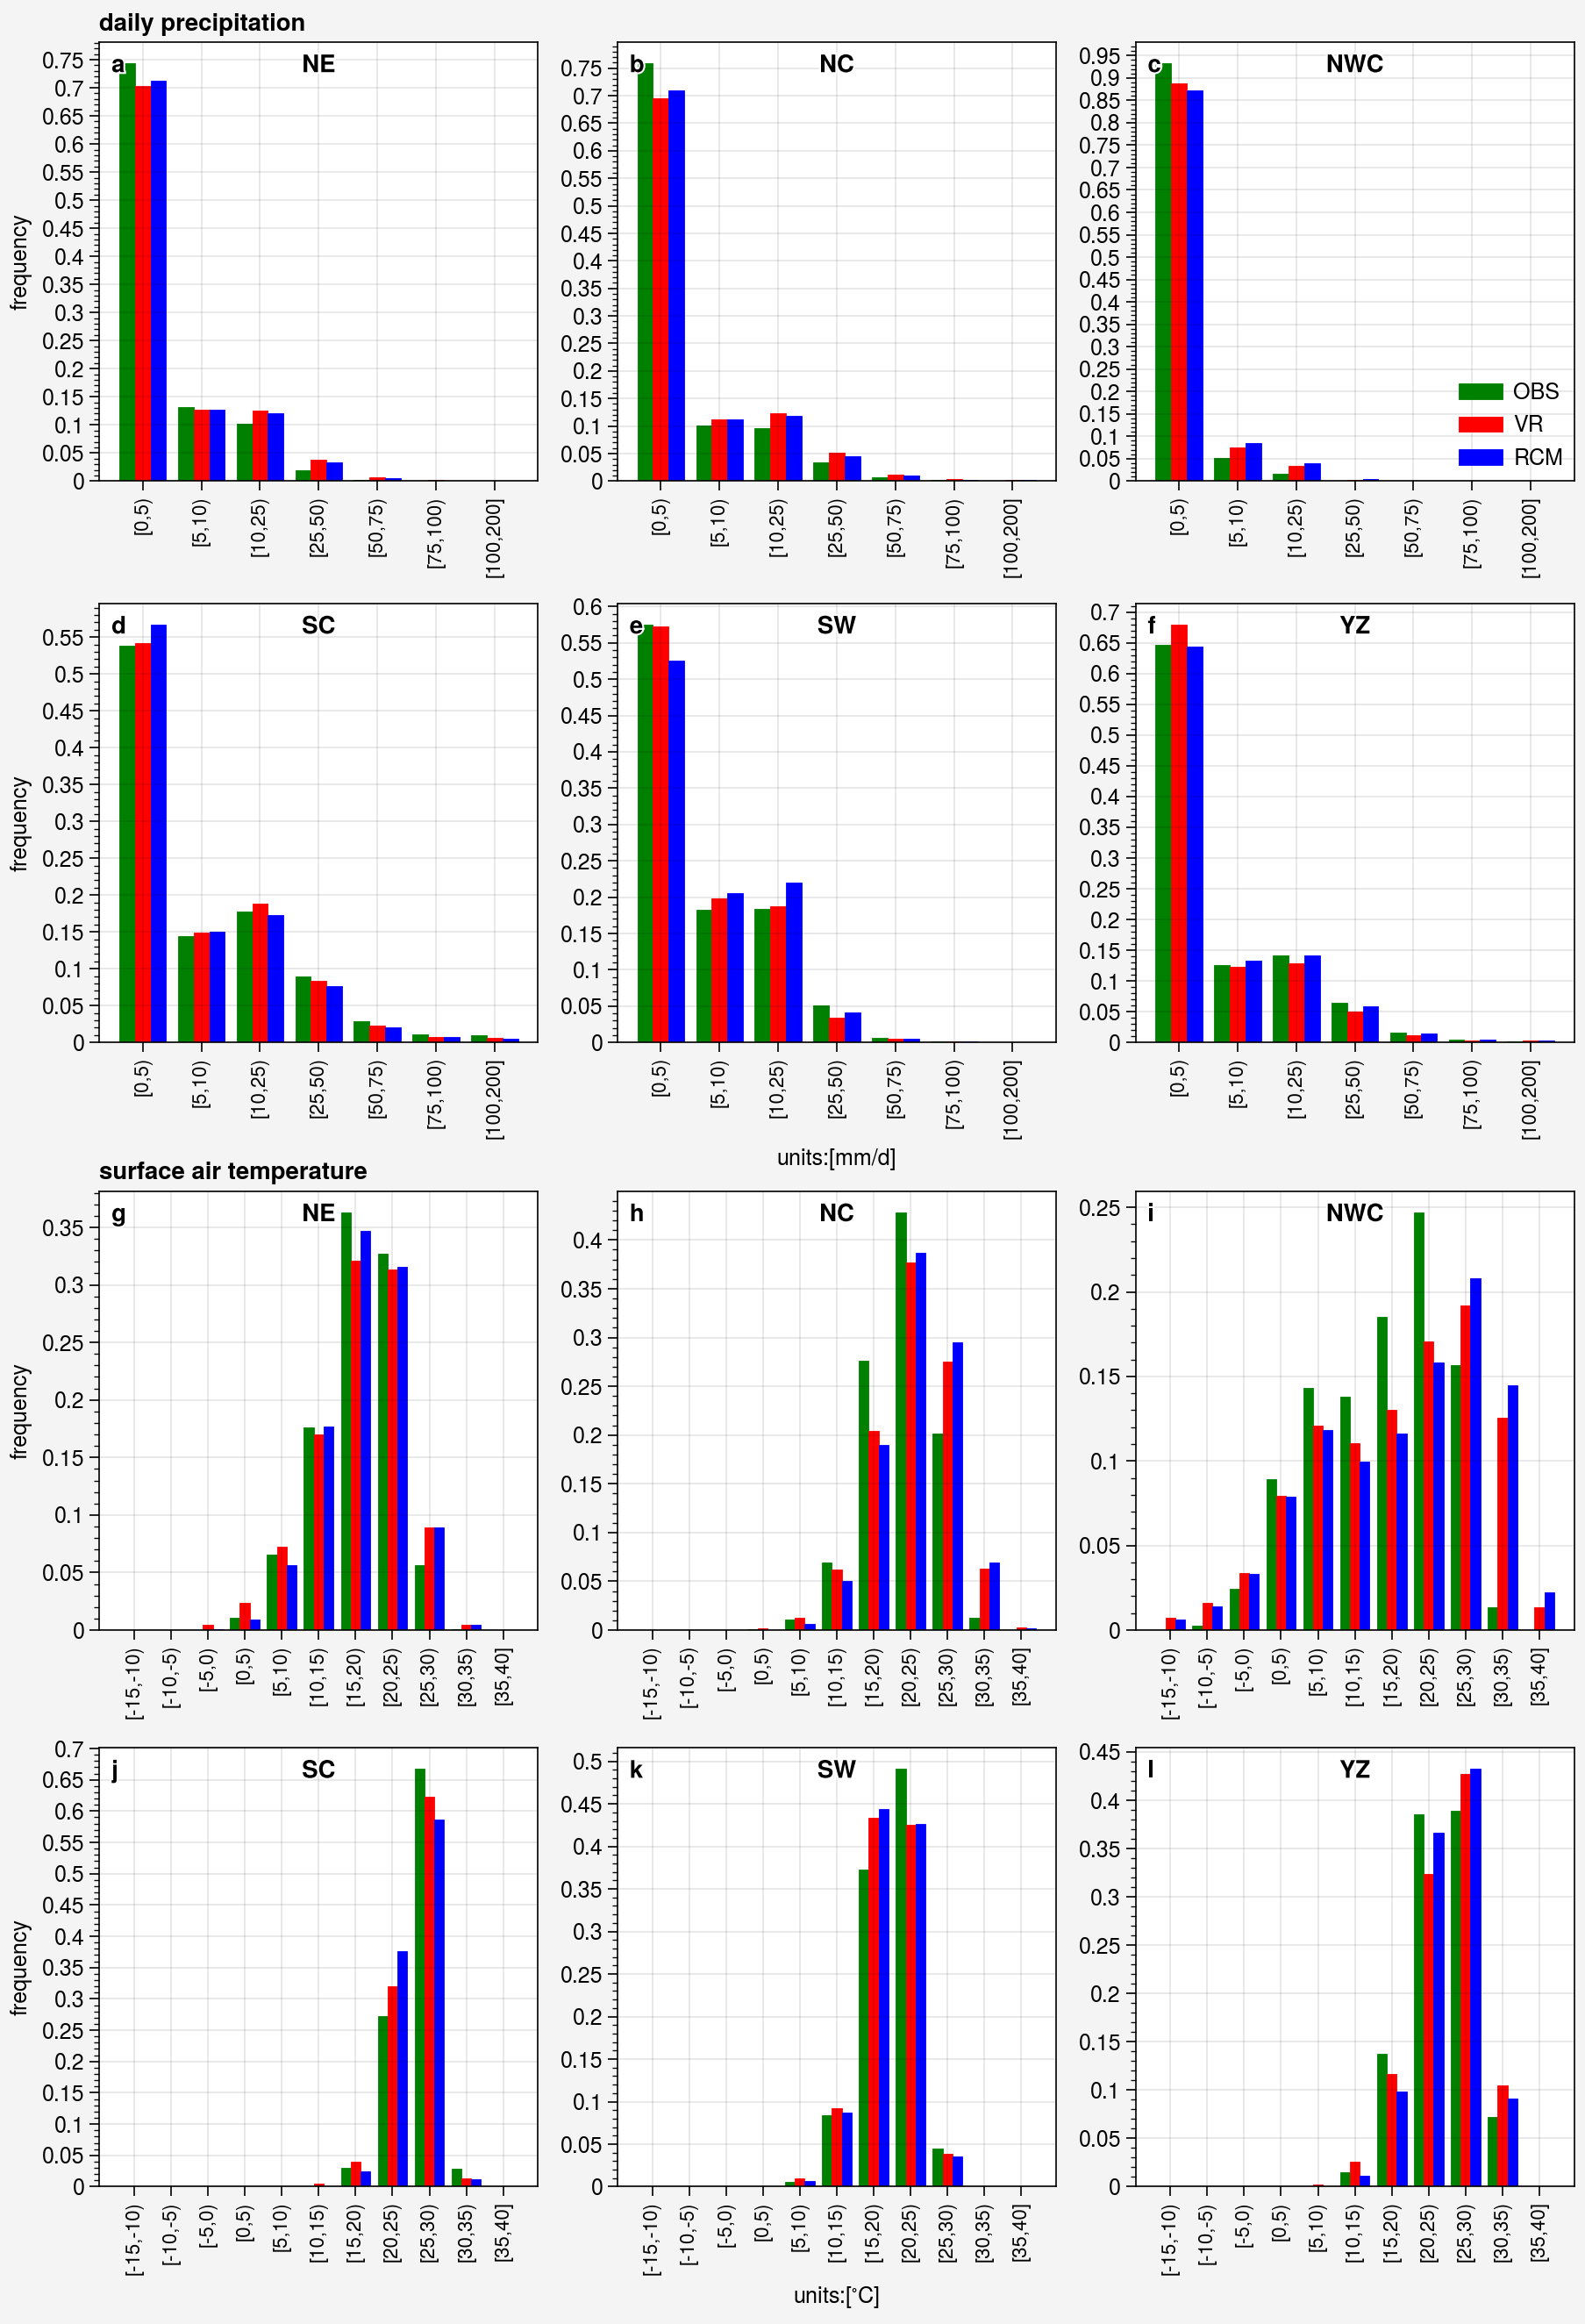

In [103]:
# fig, axs = pplt.subplots(ncols = 3, nrows = 4, wspace=0, hspace=(0,1,0), spanx=True, spany=True, share=3, figsize = (12,8))
fig, axs = pplt.subplots(ncols = 3, nrows = 4, share = 0)
# wspace hspace设置宽度， span share共享坐标轴
axs_index = 0

for iregion in ['NE', 'NC', 'NWC', 'SC', 'SW', 'YZ']:
    # precip
    barplot = axs[axs_index].bar(df_plot['precip'][iregion], cycle = ['g','r','b'])
    axs[axs_index].format(title = f'{iregion}' ,titleweight='bold',titleloc='uc')
    # t2m
    if (iregion in ['NE','NC']):
        barplot = axs[axs_index+6].bar(df_plot['t2m'][iregion], cycle = ['g','r','b'])
    elif (iregion in ['SC','SW', 'YZ']):
        barplot = axs[axs_index+6].bar(df_plot['t2m'][iregion], cycle = ['g','r','b'])
    elif (iregion in ['NWC']):
        barplot = axs[axs_index+6].bar(df_plot['t2m'][iregion], cycle = ['g','r','b'])

    axs[axs_index + 6].format(title = f'{iregion}' ,titleweight='bold',titleloc='uc')

    # 添加百分号标签，单独设置ticks（把小数转化成百分数）
    # axs[axs_index].set_yticklabels(['{:.1f}%'.format(x*100) for x in axs[axs_index].get_yticks()]) 
    axs_index = axs_index + 1
    # break

axs[0].format(ltitle = 'daily precipitation')
axs[4].format(xlabel = "units:[mm/d]")
axs[6].format(ltitle = 'surface air temperature')
axs[10].format(xlabel = "units:[" + r"$^{\circ}C$" + "]")
axs[:,0].format(ylabel = "frequency")
axs.format(
abc = True,
abcloc="ul",
# ylim = (0,0.95),
ylocator = 0.05,
xticklabelsize = 8,
xrotation = 90.,
# leftlabels=('daily precipitation', '', 'surface air temperature',''),
# xlim = (0,23),
# xlocator = 5. ,
# xminorlocator = 1. ,
# suptitle = "daily precipitation",
# ylabel = "Frequency",
# xlabel = "domain average precipitation (mm)"
)
# axs[0,:].format(ylim = (0,0.6))
# axs[1,:].format(ylim = (0,0.39))
# ----- limit setting ------
# axs[0,:].format(ylim = (0.,0.24))
# axs[1,:].format(ylim = (0.,0.38))
# axs[2,:].format(ylim = (0.,0.36))
# axs[3,:].format(ylim = (0.,0.42))
# axs[1,-1].format(ylim = (0.,0.22))
# ----- add legend -----
axs[2].legend(barplot, loc='lr', ncols=1, frame=False, labels = ['OBS','VR','RCM'], title = '')

# saving figs
# plt.savefig("./output_pic/pre&t2m_SubregionsFreq.2022.02.17.png", dpi = 600, facecolor = "white")

### type 2 绘制加密的曲线图

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:85: FutureWarning: Conversion of the second argument of issubdtype from `object` to `np.generic` is deprecated. In future, it will be treated as `np.object_ == np.dtype(object).type`.
  or np.issubdtype(array.dtype, np.object)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/si

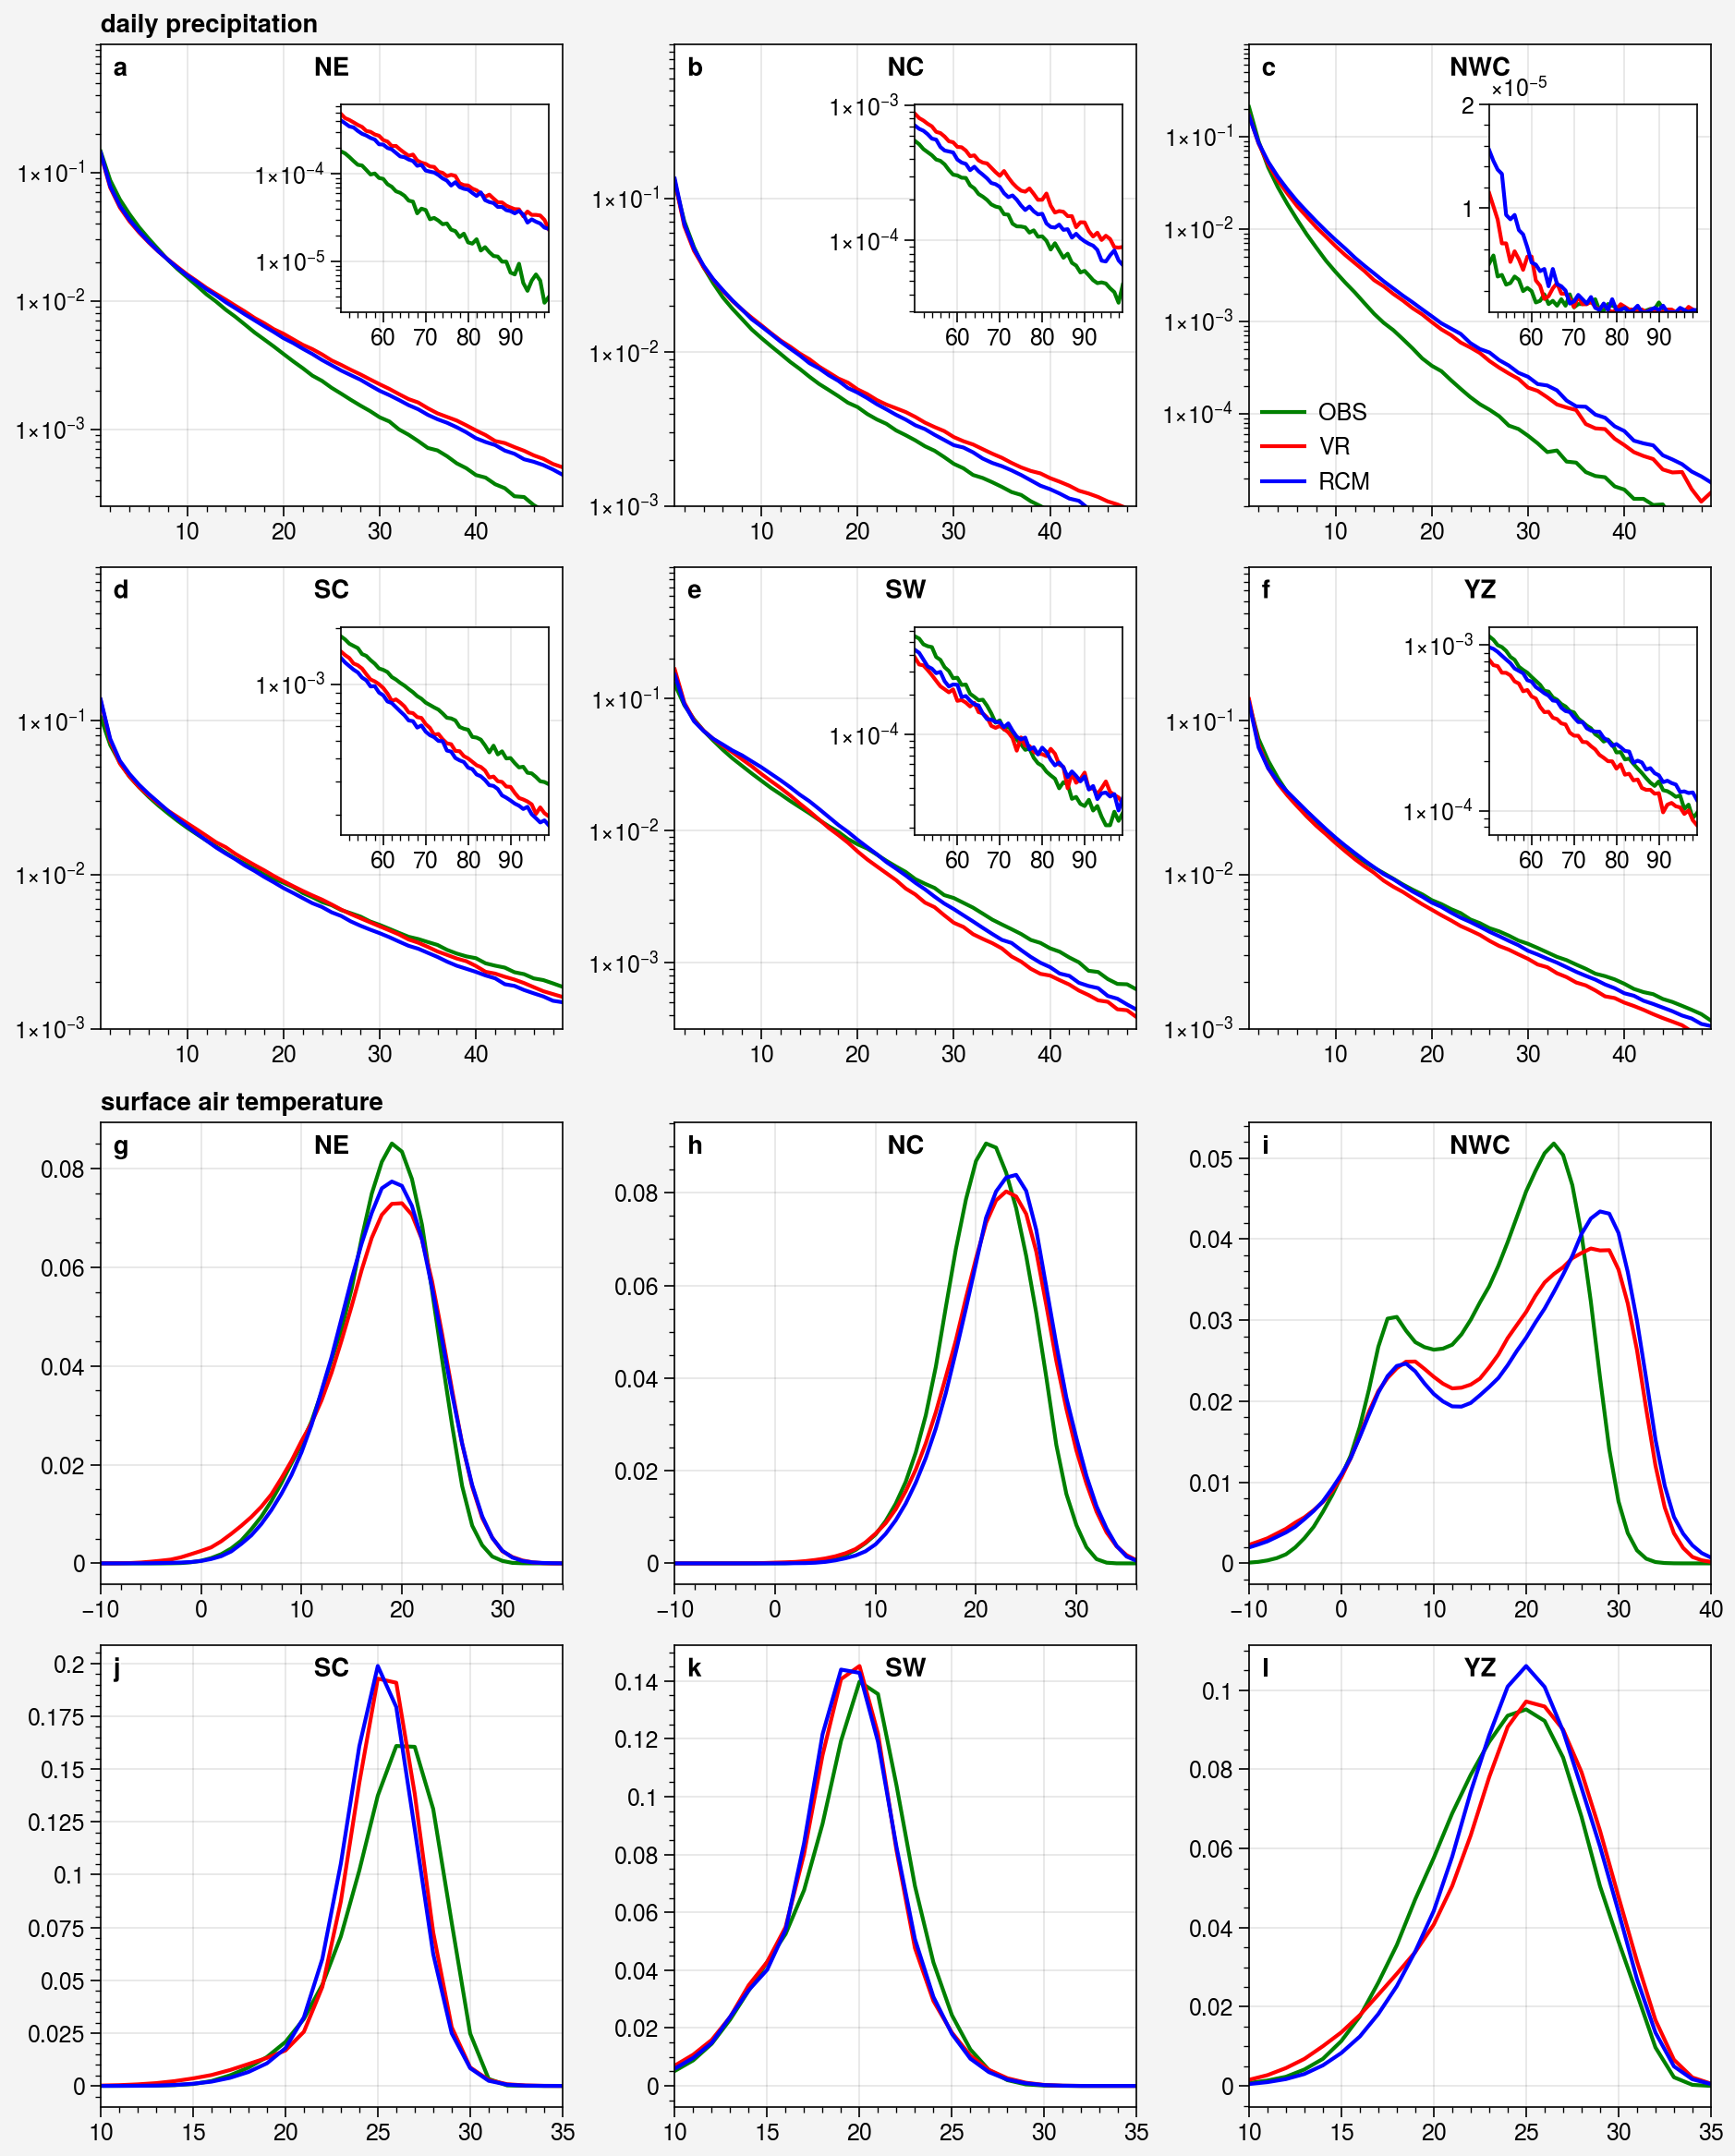

In [99]:
fig, axs = pplt.subplots(ncols = 3, nrows = 4, share = 0)


# ----- 绘制降水 ----- #
axs_ind = 0
for iregion in ['NE', 'NC', 'NWC', 'SC', 'SW', 'YZ']:
    curve_plot = axs[axs_ind].plot(df_plot['precip'][iregion][1:50], cycle = ['g','r','b'])
    axs[axs_ind].format(title = f'{iregion}' ,titleweight='bold',titleloc='uc')
    axs_ind +=1

# 绘制极端值的小图
axs_ind = 0
axs_small = {}
for iregion in ['NE', 'NC', 'NWC', 'SC', 'SW', 'YZ']:
    axs_small[iregion] = axs[axs_ind].inset_axes(bounds = (0.52, 0.42, 0.45, 0.45), transform = 'axes', zoom = False)
    curve_plot = axs_small[iregion].plot(df_plot['precip'][iregion][50:100], cycle = ['g','r','b'])
    axs_small[iregion].format(yformatter = 'sci',xlocator = [60,70,80,90], yscale = 'log')
    axs_ind +=1

axs_small['NWC'].format(yscale = 'linear',ylim = (0,2*1e-5),ylocator = [1e-5,2*1e-5])


# axs.format(yscale = 'linear', xscale = 'linear',xlocator = 10,yformatter='sci', abc = True)
axs.format(abc = True, abcloc = 'ul')
axs[0:6].format(yscale = 'log', xscale = 'linear',xlocator = 10, ylim = (1e-5,1e0), ylocator = np.array([1e-4,1e-3,1e-2,1e-1]),yformatter='sci')
axs[0].format(ylim = (10**(-3.6),1e0))
axs[1].format(ylim = (1e-3,1e0))
axs[3].format(ylim = (1e-3,1e0))
axs[4].format(ylim = (10**(-3.5),1e0))
axs[5].format(ylim = (1e-3,1e0))

# ----- 绘制气温 -----#
axs_ind = 6
for iregion in ['NE', 'NC', 'NWC', 'SC', 'SW', 'YZ']:
    curve_plot = axs[axs_ind].plot(df_plot['t2m'][iregion][:], cycle = ['g','r','b'])
    axs[axs_ind].format(title = f'{iregion}' ,titleweight='bold',titleloc='uc')
    axs_ind +=1

axs[2,0:2].format(xlim = (-10.,36.))
axs[2,2].format(xlim = (-10.,40.))
axs[3,:].format(xlim = (10.,35.))

# ----- 添加总标题 -----#

axs[2].legend(curve_plot, loc='ll', ncols=1, frame=False, labels = ['OBS','VR','RCM'], title = '')
axs[0].format(ltitle = 'daily precipitation')
axs[6].format(ltitle = 'surface air temperature')

# plt.savefig("./output_pic/pre&t2m_SubregionsFreq_LogCurve.2022.02.17.png", dpi = 600, facecolor = "white")